# Perturbed input/output
## Basic notation
- $X$: an input (shape=(N,F)).
- $\hat{y}$: an output from learnable function $f$. $\hat{y}=f(X)$
- $X_p$: a perturbed input. $X_p=X+\delta X$
- $\hat{y}_p$: an output from the perturbed input. $\hat{y}_p=f(X_p)$

## Self-supervised learning
A self-supervised objective is defined on the two outputs.
$$R(\hat{y},\hat{y}_p)$$
- For example, if $X=(x,\dot{x})$ where $x,\dot{x}$ are a position/velocity of an object, respectively.
- $f(\cdot)$ is a function to predict next state from a given current state.
- The main objective is $||X_{t+1}-f(X_t)||^2$ where $\hat{X}_t=f(X_t)$.
- We can introduce an additional constraint by introducing energy function $E(X)$.
- The energy function turns out the current energy of the object from its position/velocity.
- $E(X)=\frac{1}{2}m\dot{x}^2 + mgx$
- If a perturbation is a positive $\delta\dot{x}$ on the velocity $\dot{x}$, $E(X_p)$ should be increased.
- Thus, an additional constraint, $E(X)<E(X_p)$, can be introduced.

### A simple MLP is able to learn inequality constraint?

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import torch
device = torch.device("cuda:3")
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, 1))
        
    def forward(self, x):
        return self.net(x)




X = torch.randn((10000, 4)).to(device)
input_dim = X.shape[1]

train_loader = DataLoader(TensorDataset(X), batch_size=32, shuffle=True)

model = Net(input_dim)
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

loss_rule = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
optimizer = optim.Adam(model.parameters(), lr=0.001)

total parameters: 193


In [23]:
epochs = 1
log_interval = 100

# Training
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        batch_x = batch_data[0]
        
        # perturbation on one feature
        pert_batch_x = batch_x.detach().clone()
        perturbations = 0.1*torch.rand((batch_x.shape[0],), device=device)
        pert_batch_x[:,1] += perturbations    # X+dX
        
        # perturbation on all features 
#         perturbations = 0.1*torch.rand((batch_x.shape[0], 4), device=device)
#         pert_batch_x = batch_x.detach().clone() + perturbations    # X+dX
        
        
        y_hat = model(batch_x)
        y_hat_p = model(pert_batch_x)
        
        loss = loss_rule(y_hat, y_hat_p)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('[Train] Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(batch_x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
#         break

[Train] Epoch: 1 [0/10000 (0%)]	Loss: 0.006343
[Train] Epoch: 1 [3200/10000 (32%)]	Loss: 0.000000
[Train] Epoch: 1 [6400/10000 (64%)]	Loss: 0.000000
[Train] Epoch: 1 [9600/10000 (96%)]	Loss: 0.000000


verification ratio: 0.61


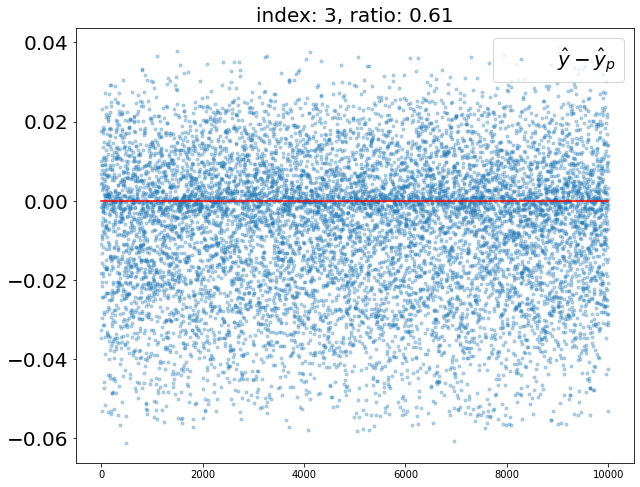

In [27]:
num_test = 10000

test_x = torch.rand((num_test,4), device=device)

# perturbation on one feature
pert_x = test_x.detach().clone()
perturbations = 0.1*torch.rand((num_test,), device=device)
ind = 3
pert_x[:,ind] += perturbations

# perturbation on all features
# pert_x = test_x.detach().clone() + torch.rand((num_test, 4), device=device)


with torch.no_grad():
    out = model(test_x).squeeze().cpu()
    pout = model(pert_x).squeeze().cpu()
    
    verification_ratio = torch.sum(out-pout < 0).item() / out.shape[0]
    
    plt.figure(0, figsize=(10,8))
    plt.plot(out-pout, '.', alpha=0.3, label=r'$\hat{y}-\hat{y}_p$')
    plt.plot([0,10000],[0,0],'r')
    plt.title('index: {}, ratio: {:.2f}'.format(ind, verification_ratio), fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    
    print('verification ratio: {:.2f}'.format(verification_ratio))
    
    


In [177]:
0.19, 0.28, 0.32, 0.99
0.00, 1.00, 0.01, 0.92

0.813

In [166]:
out.shape[0]

10000

In [134]:
pert

tensor([[0.0000, 0.8561, 0.0000, 0.0000],
        [0.0000, 0.8447, 0.0000, 0.0000],
        [0.0000, 0.2905, 0.0000, 0.0000]])

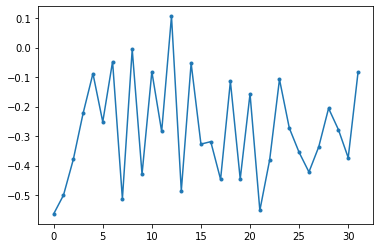

In [80]:
with torch.no_grad():
    plt.plot(y_hat[:,0].cpu(), '.-')